In [5]:
# import libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import matplotlib
import xlrd
import os
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import pickle
import random
from tensorflow import set_random_seed
import numpy as np
seed_value =10
random.seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
set_random_seed(seed_value)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation, Dropout,RepeatVector,TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [6]:
def get_dataset_for_variable(variables,excel_path):
    
    month_convert={
            4:"Arp",
            5:"May",
            6:"Jun",
            7:"Jul",
            8:"Aug",
            9:"Sep",
            10:"Oct",
            11:"Nov",
            12:"Dec",
            1:"Jan",
            2:"Feb",
            3:"Mar"
        }
    workbook = xlrd.open_workbook(excel_path) #read input
    worksheet = workbook.sheet_by_index(0)

    keys={}
    keys["Month"]=[]

    #find all keys
    forbid={}
    for i in range(3,worksheet.nrows):#for each row
        forbid[i]=1
        for var in variables:
            if var.lower() in str(worksheet.cell(i,5).value).lower(): #column3 is product name and column 5 is variable
                key=str(worksheet.cell(i,5).value)+"-"+str(worksheet.cell(i,3).value)
                keys[key]=[]
                break

    j=9 #date column begin from 9 in format

    while j<worksheet.ncols:
        date3=str(xlrd.xldate.xldate_as_datetime(worksheet.cell(2,j).value,workbook.datemode))
        final_date=date3[5]+date3[6]+"-"+date3[8]+date3[9]+"-"+date3[0]+date3[1]+date3[2]+date3[3]
        ok=0
        for i in range(3,worksheet.nrows):#for each row
            bol=str(type(worksheet.cell(i,j).value))=="<class 'float'>"
            if str(worksheet.cell(i,j).value)=='x':
                forbid[i]=0
            if bol==1:
                for var in variables:
                    if var.lower() in str(worksheet.cell(i,5).value).lower():
                        key=str(worksheet.cell(i,5).value)+"-"+str(worksheet.cell(i,3).value)
                        keys[key].append(worksheet.cell(i,j).value)
                        ok=1
                        break
            elif forbid[i]:
                for var in variables:
                    if var.lower() in str(worksheet.cell(i,5).value).lower():
                        key=str(worksheet.cell(i,5).value)+"-"+str(worksheet.cell(i,3).value)
                        keys[key].append(0.0)
                        ok=1
                        break
        if ok==1:
            keys["Month"].append(final_date)
        j+=1

    #convert it to proper pandas format
    colname=[]
    leng=0
    for key in keys:
        colname.append(key)
        leng=len(keys[key])
    datarow=[]
    for w in range(0,leng):
        rw=[]
        for key in keys:
            rw.append(keys[key][w])
        rw.append(float(w))
        datarow.append(rw)
    colname.append('Index')
    dataset = pd.DataFrame(datarow,columns=colname).set_index('Index')
    return dataset

In [7]:
def get_dataset_for_product(dataset,product_name):
    column_name='Net Migrations(Norm)-%s'%product_name #product_key_name 
    dataset=pd.DataFrame(dataset[column_name])
    plt.plot(dataset)
    plt.show()
    return dataset,column_name

In [8]:
def normalize_dataset(dataset,column_name,model_path):
    dataframe = dataset
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    scalerfile = os.path.join(model_path,'scaler-%s.sav'%column_name)
    pickle.dump(scaler, open(scalerfile, 'wb'))
    return dataset,scaler

In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
def train_model(trainX, trainY,model_save_path):
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    model = Sequential()
    model.add(LSTM(30, return_sequences= True,input_shape=( 1,look_back)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
    print(model.summary())
    history = model.fit(trainX, trainY, epochs=300, batch_size=6, verbose=1)
    model.save(model_save_path)
    print("Model Saved at -",model_save_path)
    return history

In [11]:
from keras.models import load_model
def predict_values(testX,no_of_pred,model_save_path,scaler_save_path):
    scaler = pickle.load(open(scaler_save_path, 'rb'))
    final_output = []
    model = load_model(model_save_path)
    for i in range(0,no_of_pred):
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[0]))
        testPredict = model.predict(testX)
        testX = np.array(testPredict[0])
        output = scaler.inverse_transform(testPredict)
        output = output[0].tolist()
        final_output.append(output[0])
    return final_output

In [34]:
import os
model_path ="models"
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [35]:
# creating a dataset with needed columns and its values
variables=["Net Migration"] # variable name
excel_path = 'PrivatizedDataforParticipants.xlsx'
dataset = get_dataset_for_variable(variables,excel_path)

In [36]:
dataset.head()

,Month,Net Migrations(Norm)-Panther,Net Migrations(Norm)-Leopard,Net Migrations(Norm)-Lion
Index,,,,
0.0,04-01-2016,1.474487,-1.517807,0.0
1.0,05-01-2016,1.465958,-1.499497,0.0
2.0,06-01-2016,0.511313,0.549954,0.0
3.0,07-01-2016,0.688626,0.169296,0.0
4.0,08-01-2016,0.473906,0.630261,0.0


Enter the product name(Panther/Leopard/Lion):leopard


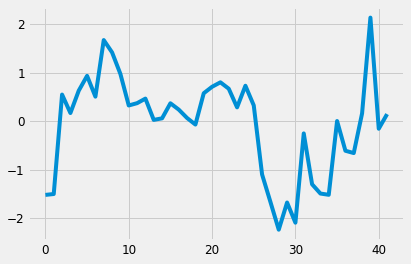

In [37]:
product_name = str(input("Enter the product name(Panther/Leopard/Lion):")).title()
dataset,column_name = get_dataset_for_product(dataset,product_name)

In [38]:
dataset,scaler = normalize_dataset(dataset,column_name,model_path)

In [39]:
look_back = 1 # change the look bach period here
trainX, trainY = create_dataset(dataset, look_back)

In [40]:
# taking last 6 values for cross validation
valX = trainX[-6:]
trainX = trainX[:-6]
valY = trainY[-6:]
trainY = trainY[:-6]

In [41]:
trainX.shape,trainY.shape

((35, 1), (35,))

In [42]:
model_save_path = os.path.join(model_path,column_name+".h5")
scaler_save_path = os.path.join(model_path,'scaler-%s.sav'%column_name)
history = train_model(trainX, trainY,model_save_path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 30)             3840      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 30)             7320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________
None
E

35/35 [==============================] - 0s 1ms/step - loss: 0.0229 - mean_squared_error: 0.0229
Epoch 66/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0274 - mean_squared_error: 0.0274
Epoch 67/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0222 - mean_squared_error: 0.0222
Epoch 68/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0252 - mean_squared_error: 0.0252
Epoch 69/300
35/35 [==============================] - 0s 940us/step - loss: 0.0221 - mean_squared_error: 0.0221
Epoch 70/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0267 - mean_squared_error: 0.0267
Epoch 71/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0242 - mean_squared_error: 0.0242
Epoch 72/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0250 - mean_squared_error: 0.0250
Epoch 73/300
35/35 [==============================] - 0s 2ms/step - loss: 0.0272 - mean_squared_error: 0.0272
Epoch 74/300
35/35 [=

Epoch 139/300
35/35 [==============================] - 0s 2ms/step - loss: 0.0280 - mean_squared_error: 0.0280
Epoch 140/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0269 - mean_squared_error: 0.0269
Epoch 141/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0269 - mean_squared_error: 0.0269
Epoch 142/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0267 - mean_squared_error: 0.0267
Epoch 143/300
35/35 [==============================] - 0s 969us/step - loss: 0.0260 - mean_squared_error: 0.0260
Epoch 144/300
35/35 [==============================] - 0s 940us/step - loss: 0.0273 - mean_squared_error: 0.0273
Epoch 145/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0231 - mean_squared_error: 0.0231
Epoch 146/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0273 - mean_squared_error: 0.0273
Epoch 147/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0250 - mean_squared_error: 0.02

35/35 [==============================] - 0s 969us/step - loss: 0.0263 - mean_squared_error: 0.0263
Epoch 213/300
35/35 [==============================] - 0s 826us/step - loss: 0.0251 - mean_squared_error: 0.0251
Epoch 214/300
35/35 [==============================] - 0s 940us/step - loss: 0.0261 - mean_squared_error: 0.0261
Epoch 215/300
35/35 [==============================] - 0s 912us/step - loss: 0.0223 - mean_squared_error: 0.0223
Epoch 216/300
35/35 [==============================] - 0s 912us/step - loss: 0.0280 - mean_squared_error: 0.0280
Epoch 217/300
35/35 [==============================] - 0s 883us/step - loss: 0.0237 - mean_squared_error: 0.0237
Epoch 218/300
35/35 [==============================] - 0s 912us/step - loss: 0.0230 - mean_squared_error: 0.0230
Epoch 219/300
35/35 [==============================] - 0s 855us/step - loss: 0.0244 - mean_squared_error: 0.0244
Epoch 220/300
35/35 [==============================] - 0s 940us/step - loss: 0.0239 - mean_squared_error: 0.02

35/35 [==============================] - 0s 969us/step - loss: 0.0263 - mean_squared_error: 0.0263
Epoch 285/300
35/35 [==============================] - 0s 940us/step - loss: 0.0254 - mean_squared_error: 0.0254
Epoch 286/300
35/35 [==============================] - 0s 997us/step - loss: 0.0229 - mean_squared_error: 0.0229
Epoch 287/300
35/35 [==============================] - 0s 855us/step - loss: 0.0220 - mean_squared_error: 0.0220
Epoch 288/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0229 - mean_squared_error: 0.0229
Epoch 289/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0218 - mean_squared_error: 0.0218
Epoch 290/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0250 - mean_squared_error: 0.0250
Epoch 291/300
35/35 [==============================] - 0s 940us/step - loss: 0.0235 - mean_squared_error: 0.0235
Epoch 292/300
35/35 [==============================] - 0s 1ms/step - loss: 0.0257 - mean_squared_error: 0.0257
Epoch

In [43]:
## cross validation
no_of_pred = 6 #change forecast horizon here
testX = np.array([trainY[-1]]) # taking the last value to predict next no_of_pred predictions
final_output = predict_values(testX,no_of_pred,model_save_path,scaler_save_path)

In [44]:
#calculating MAPE SCORE
def cal_mape(ypred,y):
    mape = max(0, 1 - abs(y-ypred)/abs(y))
    return mape
scores =[]
for y_pred,y in zip(final_output,valY):
    y = scaler.inverse_transform(y.reshape(-1, 1))[0][0]
    print(y_pred,y)
    scores.append(cal_mape(y_pred,y))
print(100 * sum(scores)/len(scores))

0.013895739801228046 -0.6080824
0.020779533311724663 -0.65562457
0.02600879967212677 0.16126461
0.029984405264258385 2.1352262
0.033008504658937454 -0.1545048
0.03530926629900932 0.14680937
6.930566372311863


In [45]:
## final prediciton
no_of_pred = 6 # prediction horizon
testX = np.array([valY[-1]]) # take the last month value to predict next 6
testX = scaler.transform(np.array(testX).astype('float32').reshape(-1, 1))
model_save_path = os.path.join(model_path,column_name+".h5")
scaler_save_path = os.path.join(model_path,'scaler-%s.sav'%column_name)
final_output = predict_values(testX,no_of_pred,model_save_path,scaler_save_path)

In [46]:
final_output 

[0.43643009662628174,
 0.3495137393474579,
 0.28063204884529114,
 0.22649836540222168,
 0.18424150347709656,
 0.1514333039522171]

In [ ]:
# ## checkin constraint that sum of all products should be close to zer0
# no_of_pred = 6 # prediction horizon
# final_outputs = {}
# products =['Lion','Panther','Leopard']
# variables=["Net Migration"]
# look_back = 1
# for product in products:
#     print(product)
    
#     excel_path = 'PrivatizedDataforParticipants.xlsx'
#     dataset = get_dataset_for_variable(variables,excel_path)
    
#     dataset,column_name = get_dataset_for_product(dataset,product)
    
#     dataset,scaler = normalize_dataset(dataset,column_name,model_path)
    
#     trainX, trainY = create_dataset(dataset, look_back)
    
#     model_save_path = os.path.join(model_path,column_name+".h5")
#     history = train_model(trainX, trainY,model_save_path)
    
#     testX = np.array([trainY[-1]]) # take the last month value to predict next 6
#     scaler_save_path = os.path.join(model_path,'scaler-%s.sav'%column_name)
    
#     final_output = predict_values(testX,no_of_pred,model_save_path,scaler_save_path)
#     final_outputs[product]=final_output

In [ ]:
# print(final_outputs)
# outputs =[]
# for key,value in final_outputs.items():
#     outputs.append(value)
# list(map(sum, zip(*outputs)))